<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install "gymnasium[classic_control]" > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

# Added dependency
!pip install tensorflow > /dev/null 2>&1
!pip install imageio > /dev/null 2>&1
!pip install PIL > /dev/null 2>&1
!pip install opencv-python > /dev/null 2>&1
!pip instal moviepy > /dev/null 2>&1



## Importing dependencies and define helper functions

In [2]:
import gymnasium as gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE # Mean Square Error
from tensorflow.keras.optimizers.legacy import Adam

## Tutorial: Loading CartPole environment

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [4]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [5]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [6]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: (array([ 0.02779018,  0.02979166,  0.03662649, -0.04988537], dtype=float32), {})


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [7]:
env.reset()
observation, reward, done, truncated, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)
print("Is this round truncated?", truncated)
print("Info", info)

New observations after choosing action 0: [-0.0112643  -0.18523078  0.00415645  0.2857691 ]
Reward for this step: 1.0
Is this round done? False
Is this round truncated? False
Info {}


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [8]:
observation = env.reset()
cumulative_reward = 0

# done is the same as teminated
done = False
while not done:
    observation, reward, done, truncated, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


In [9]:
# Note that the env.step method accept 5 return value not 4 anymore

## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [10]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

For Task 1, we can show the observation and chosen action below:

In [11]:
observation = env.reset()
action = rand_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: (array([ 0.01029618,  0.04940296, -0.01750837,  0.0177334 ], dtype=float32), {})
Chosen action: 0


#### For the development RL agent using Deep-Q learning please refer to the `Training.ipynb` file.<br>
Now, we load our trained parameter into this notebook

In [12]:
STATE_SIZE = env.observation_space.shape  # The model can return 4 state attributes
NUM_OF_ACTION = env.action_space.n        # the model can only use 2 action push_left(0), push_right(1)

model = Sequential([
    Input(shape = STATE_SIZE),
    Dense(units = 128, activation = 'relu'),
    Dense(units = 256, activation = 'relu'),
    Dense(units = NUM_OF_ACTION, activation = 'linear')
])



model.load_weights('cart_pole_model_temp.h5')

Now the agent will take action according to the trained model

In [13]:
observation = env.reset()
state = observation[0]
state = np.expand_dims(state, axis = 0)

# Pass the state into the model
q_values = model(state)

# Pick the action with the higher q_value
action = np.argmax(q_values.numpy()[0])

print("Observation:", observation)
print("Chosen action:", action)

Observation: (array([ 0.01758243,  0.04594364, -0.02179873,  0.04052223], dtype=float32), {})
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

Run the model for 100 episodes

In [14]:
episode_results = []

for i in range(100):
    state = env.reset()[0]
    total_reward = 0
    done = False
    truncated = False
    
    # Some time the model perform too good it will take forever to run the code
    # So we have to add "truncated" to stop the model from running further after the total point is 500
    while not done and not truncated:
        state = np.expand_dims(state, axis = 0)
        q_values = model(state)
        action = np.argmax(q_values.numpy()[0])
        state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
    
    print(f"Episode {i + 1} - Total Reward: {total_reward}")
    episode_results.append(total_reward)
    
avg_reward = np.average(episode_results)
episode_results = np.array(episode_results)

Episode 1 - Total Reward: 500.0
Episode 2 - Total Reward: 500.0
Episode 3 - Total Reward: 500.0
Episode 4 - Total Reward: 500.0
Episode 5 - Total Reward: 500.0
Episode 6 - Total Reward: 500.0
Episode 7 - Total Reward: 500.0
Episode 8 - Total Reward: 500.0
Episode 9 - Total Reward: 500.0
Episode 10 - Total Reward: 500.0
Episode 11 - Total Reward: 500.0
Episode 12 - Total Reward: 500.0
Episode 13 - Total Reward: 500.0
Episode 14 - Total Reward: 500.0
Episode 15 - Total Reward: 500.0
Episode 16 - Total Reward: 500.0
Episode 17 - Total Reward: 500.0
Episode 18 - Total Reward: 299.0
Episode 19 - Total Reward: 500.0
Episode 20 - Total Reward: 500.0
Episode 21 - Total Reward: 500.0
Episode 22 - Total Reward: 500.0
Episode 23 - Total Reward: 500.0
Episode 24 - Total Reward: 500.0
Episode 25 - Total Reward: 500.0
Episode 26 - Total Reward: 500.0
Episode 27 - Total Reward: 500.0
Episode 28 - Total Reward: 500.0
Episode 29 - Total Reward: 500.0
Episode 30 - Total Reward: 500.0
Episode 31 - Total 

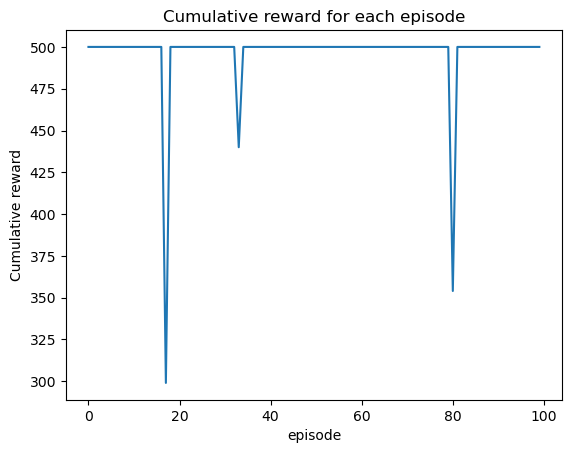

In [15]:
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [16]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 495.93
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [17]:
import utils
utils.create_video("video/video.mp4", env, model, test = False)
utils.show_video()

OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
